In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import utils
import os

C:\Users\msubr\Anaconda3\envs\bert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("UCF-crime-frames-descriptions-partitions.csv")

In [3]:
data.head(2)

,Unnamed: 0,frame,directory,class,Description,partition
0,0,Abuse001_x264.mp4_frame_000000.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train
1,1,Abuse001_x264.mp4_frame_000010.jpg,Abuse_frames,Normal,a man is standing in the middle of a room,train


In [4]:
train = data.loc[data["partition"] == "train"]
val = data.loc[data["partition"] == "validation"]
test = data.loc[data["partition"] == "test"]

In [6]:
path = "d:/data/UCF-crime/Anomaly-Videos-description-features-mean"
if os.path.isfile("train_desc_mean.npy"):
    print("Loading bulk")
    X = np.load("train_desc_mean.npy")
    V = np.load("val_desc_mean.npy")
    X = torch.tensor(X, dtype=torch.float32)
    V = torch.tensor(V, dtype=torch.float32)
    y = list(train["class"])
    y = np.array([utils.labels[lbl] for lbl in y])
    y = torch.tensor(y, dtype=torch.float32)
    y_val = list(val["class"])
    y_val = np.array([utils.labels[lbl] for lbl in y_val])
    y_val = torch.tensor(y_val, dtype=torch.float32)
else:
    print("Loading individually")
    V, y_val = utils.get_data(val, path, n=2560)
    X, y = utils.get_data(train, path, n=2560)
    np.save( "train_desc_mean.npy", X.numpy())
    np.save( "val_desc_mean.npy", V.numpy())

Loading bulk


In [7]:
labels_counts = torch.tensor([(y==i).sum() for i in range(len(utils.labels))])
weights = 1 - labels_counts / len(X)    

In [8]:
model = nn.Sequential(
    nn.Linear(2560, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [9]:
sum(param.numel() for param in model.parameters())

921098

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Sequential(
  (0): Linear(in_features=2560, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=10, bias=True)
)

In [11]:
weights = weights.to(device)
loss_fn = nn.CrossEntropyLoss(weights)  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [12]:
n_epochs = 30
batch_size = 64
for epoch in range(n_epochs):
    acc = 0
    perm = torch.randperm(len(X))
    for i in range(0, len(X), batch_size):
        Xbatch = X[perm[i:i+batch_size]]
        Xbatch = Xbatch.to(device)
        y_pred = model(Xbatch)
        ybatch = y[perm[i:i+batch_size]]
        ybatch = ybatch.type(torch.LongTensor)
        ybatch = ybatch.to(device)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc += utils.get_acc(y_pred, ybatch, return_sum=True)
    val_pred = utils.evaluate(V, model, device, batch_size)
        
    print(f'Finished epoch {epoch}, latest loss {loss}, acc {acc/len(X)} val_acc {utils.get_acc(val_pred, y_val)}')

Finished epoch 0, latest loss 1.6478763818740845, acc 0.6608884930610657 val_acc 0.6777547597885132
Finished epoch 1, latest loss 1.2454229593276978, acc 0.6853679418563843 val_acc 0.6751681566238403
Finished epoch 2, latest loss 1.500439167022705, acc 0.6960892677307129 val_acc 0.6687015295028687
Finished epoch 3, latest loss 1.7961853742599487, acc 0.6994965672492981 val_acc 0.6503880023956299
Finished epoch 4, latest loss 1.5247677564620972, acc 0.7004712224006653 val_acc 0.6419554948806763
Finished epoch 5, latest loss 1.3283365964889526, acc 0.7014056444168091 val_acc 0.629125714302063
Finished epoch 6, latest loss 1.0665780305862427, acc 0.7029522061347961 val_acc 0.6337299346923828
Finished epoch 7, latest loss 1.0882959365844727, acc 0.7043135166168213 val_acc 0.629177451133728
Finished epoch 8, latest loss 1.0014662742614746, acc 0.7059003710746765 val_acc 0.6383342146873474
Finished epoch 9, latest loss 1.2913957834243774, acc 0.7077852487564087 val_acc 0.6371960639953613
Fin

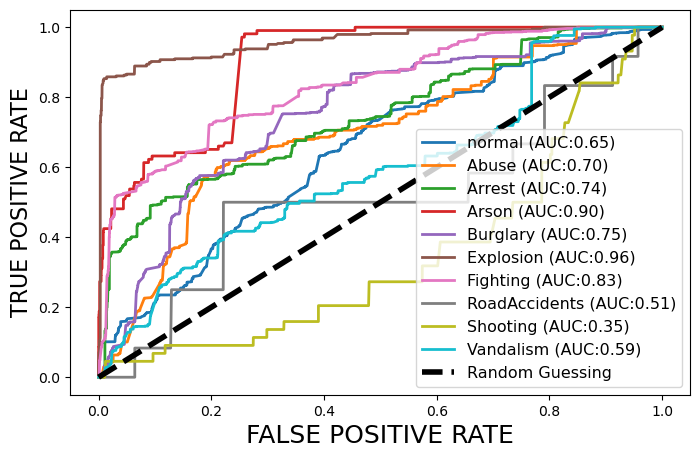

ROC AUC score: 0.6991321017536525


In [14]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y_val , val_pred, average = "macro"))

In [15]:
utils.get_acc_per_lbl(val_pred, y_val)

0, presc 0.74, recall 0.86, f1 0.79	 total 12895 Normal
1, presc 0.20, recall 0.03, f1 0.06	 total 646 Abuse
2, presc 0.57, recall 0.36, f1 0.44	 total 1321 Arrest
3, presc 0.09, recall 0.42, f1 0.14	 total 106 Arson
4, presc 0.25, recall 0.16, f1 0.20	 total 1767 Burglary
5, presc 0.77, recall 0.72, f1 0.75	 total 388 Explosion
6, presc 0.40, recall 0.36, f1 0.38	 total 1132 Fighting
7, presc nan, recall 0.00, f1 nan	 total 12 RoadAccidents
8, presc nan, recall 0.00, f1 nan	 total 44 Shooting
9, presc 0.07, recall 0.02, f1 0.03	 total 1019 Vandalism


In [16]:
utils.get_acc(val_pred, y_val)

tensor(0.6551)

In [17]:
X_pred = utils.evaluate(X, model, device, batch_size)

In [18]:
utils.get_acc_per_lbl(X_pred, y)

0, presc 0.83, recall 0.86, f1 0.84	 total 84684 Normal
1, presc 0.55, recall 0.16, f1 0.25	 total 2593 Abuse
2, presc 0.64, recall 0.76, f1 0.69	 total 10454 Arrest
3, presc 0.54, recall 0.48, f1 0.51	 total 4984 Arson
4, presc 0.56, recall 0.60, f1 0.58	 total 8211 Burglary
5, presc 0.59, recall 0.56, f1 0.58	 total 2138 Explosion
6, presc 0.53, recall 0.58, f1 0.55	 total 6178 Fighting
7, presc nan, recall 0.00, f1 nan	 total 689 RoadAccidents
8, presc nan, recall 0.00, f1 nan	 total 1568 Shooting
9, presc 0.46, recall 0.23, f1 0.31	 total 2646 Vandalism


In [19]:
utils.get_acc(X_pred, y)

tensor(0.7539)

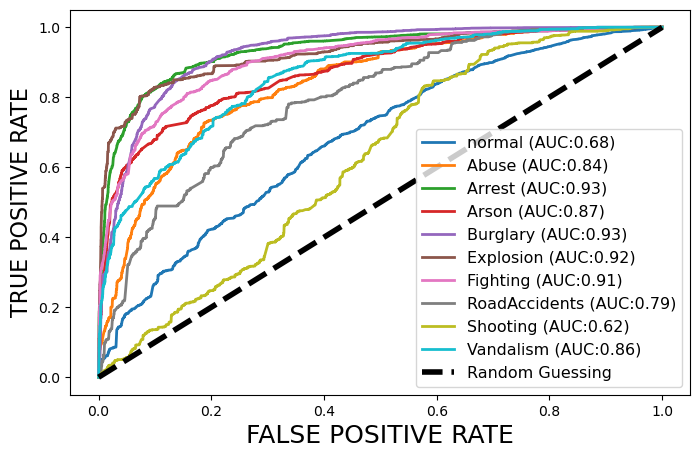

ROC AUC score: 0.8350652031700261


In [20]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y , X_pred, average = "macro"))

In [21]:
torch.save(model.state_dict(), "models/model_image_desc_features.pt")